First, we are going to extract some features about the timbre from our dataset. The features we are pulling out are:

* Spectral Flux - The rate of which the power spectrum is changing. Calculated by taking the euclidian distance between the current frame and the previous frame
* Zero Crossing Rate - The rate at which the signal changes from positive to negative and vice versa. It is commonly used in speech recognition.
* Low Energy Feature - The percentage of analysis windows that have less root mean square energy than the average RMS energy across the texture window. The reason we use this for this is that the RMS is decent way to approximate loudness, so music with gaps of silence will have a lower percentage than continuous music which would have a higher percentage
* Spectral Centroid - Indicates where the center of mass of the spectrum is, and it is commonly associated with the "brightness" of a sound
* Mel-frequency cepstrum coefficients - Another commonly used feature in speech recognition, these are the coefficients of a representation of the power spectrum of the audio


In [32]:
from pymir import SpectralFlux
import numpy as np
import math
import glob
import os
import pymir

"""Used to extract the necessary features for training from a directory of mp3 files"""
centroidCol = 0
stdcentroidCol = 1
rolloffCol = 2
stdrolloffCol = 3
fluxCol = 4
stdfluxCol = 5
zcrCol = 6
stdzcrCol = 7
lowEnergyCol = 8
#mfcc's are in columns 9-13
mfccStartCol = 9
stdmfccStartCol = 14

#Slightly Modified version of pymir's spectralFlux function
def spectralFlux(spectra):
    """
    Compute the spectral flux between consecutive spectra to reflect the papers implementation
    """
    spectralFlux = []
    # Compute flux for zeroth spectrum
    flux = 0
    for bin in spectra[0]:
        flux = flux + abs(bin)
      
    spectralFlux.append(flux)
    
    # Compute flux for subsequent spectra
    for s in range(1, len(spectra)):
        prevSpectrum = spectra[s - 1]
        spectrum = spectra[s]
        
        flux = 0
        for bin in range(0, len(spectrum)):
            diff = spectrum[bin] - prevSpectrum[bin]
            diff = pow(diff,2)
            flux = flux + diff
            
        spectralFlux.append(flux)
        
    return spectralFlux

#Slightly Modified version of pymir's zcr function
def zcr(fixedFrame):
    """
    Compute the Zero-crossing rate (ZCR)
    """
    zcr = 0
    for i in range(1, len(fixedFrame)):
        if (fixedFrame[i - 1] * fixedFrame[i]) < 0:
            zcr = zcr + 1

    return zcr / (2.0)

#Calculate Low Energy Feature - The percentage of analysis windows that 
#have less RMS energy than the average RMS energy across the texture window
def lef(textureWindow):
    rmsVals = []
    for window in textureWindow:
        e = window.energy()
        rms = 0
        for n in e:
            rms = (rms + pow(n,2))
        rmsVals.append(math.sqrt(rms/len(e)))
    avgRMSEnergy = np.sum(rmsVals)/(len(rmsVals))
    lessRMSCount = 0
    for rms in rmsVals:
        if rms < avgRMSEnergy:
            lessRMSCount += 1
    return lessRMSCount/(len(rmsVals)*1.0)

# The means and standard deviations of these features are calculated over a "texture" window of 1 second consisting 
#of 40 "analysis" windows of 20 milliseconds (512 samples at sampleRate=22050 sampling rate)
def getTimbreData(fileData):
    analysisWindowSize = 512
    analysisWindowsPerTextureWindow = 43
    fixedFrames = fileData.frames(analysisWindowSize)
    numFrames = len(fixedFrames)
    audioData = np.zeros(shape = (math.floor(numFrames/(analysisWindowsPerTextureWindow*1.0)) ,19))
    adIndexCount = 0
    spectra = [f.spectrum() for f in fixedFrames]
    flux = spectralFlux(spectra)
    centroids = []
    rolloffs = []
    fluxs = []
    zcrs = []
    mfccs = [[],[],[],[],[]]
    
    for x in range(0,numFrames):
        #At the end of a Texture Window, so add the values to the audioData matrix
        if (x%analysisWindowsPerTextureWindow == 0 and x!=0):
            audioData[adIndexCount][centroidCol] = np.sum(centroids)/len(centroids)
            audioData[adIndexCount][stdcentroidCol] = np.std(centroids)
            audioData[adIndexCount][rolloffCol] = np.sum(rolloffs)/len(rolloffs)
            audioData[adIndexCount][stdrolloffCol] = np.std(rolloffs)
            audioData[adIndexCount][fluxCol] = np.sum(fluxs)/len(fluxs)
            audioData[adIndexCount][stdfluxCol] = np.std(fluxs)
            audioData[adIndexCount][zcrCol] = np.sum(zcrs)/len(zcrs)
            audioData[adIndexCount][stdzcrCol] = np.std(zcrs)
            
            for z in range(0,5):
                audioData[adIndexCount][mfccStartCol+z] = np.sum(mfccs[z])/len(mfccs[z])
                audioData[adIndexCount][stdmfccStartCol+z] = np.std(mfccs[z])
            audioData[adIndexCount][lowEnergyCol] = lef(fixedFrames[(x-analysisWindowsPerTextureWindow):x])

            adIndexCount = adIndexCount+1
            centroids = []
            rolloffs = []
            fluxs = []
            zcrs = []
            mfccs = [[],[],[],[],[]]
        subSpectra = spectra[x]
        fixedFrame = fixedFrames[x]
        centroids.append(subSpectra.centroid())
        rolloffs.append(subSpectra.rolloff())
        fluxs.append(flux[x])
        zcrs.append(zcr(fixedFrame))
        #Calculate first 5 Mel-Frequency Cepstral Coefficients
        tempMFCC = subSpectra.mfcc2(numFilters = 6)
        
        for y in range(0,5):
            #mfccs[y].append(subSpectra.mfcc(y+1,NumFilters = 6))
            mfccs[y].append(tempMFCC[y+1])
        
    return audioData

Now that we have all of the code for data extraction, we can move on to actually pulling the data out of our mp3 files. The dataset I am using can be found here:http://marsyasweb.appspot.com/download/data_sets/ . We are going to save the data as we go, so we don't need to waste time analyzing the mp3 files again later on:


In [ ]:
mp3DataFilePath = "/Downloads/mp3SampleAudio"
#mp3DataFilePath = "/mp3SampleAudio"

genres = os.listdir(mp3DataFilePath)
print "Examining MP3 files and extracting data"
for genre in genres:
    print "Looking at the data for the genre: " + genre
    for fname in glob.glob(mp3DataFilePath + "/" + genre + "/*.mp3"):
        ad = getTimbreData(pymir.AudioFile.open(fname,sampleRate=22050))
        np.save(mp3DataFilePath + "/" + genre + "/" + os.path.basename(fname)[0:-4] + ".npy", ad)

Now, lets just try out some classification algorithms with the raw data just to see what kind of accuracy we get. First, we read the data back in:

In [34]:
import sklearn.cross_validation as cv

#Reading the data
npyDataFilePath = "/Dropbox/mp3numpyData2/"
genres = os.listdir(npyDataFilePath)

X = []
Y = []

genreRanges = dict()
for genre in genres:
    genreRange = [len(X)]
    for fname in glob.glob(npyDataFilePath + "/" + genre + "/*.npy"):
        npArr = np.load(fname)
        for arr in npArr:
            if(not np.isnan(arr).any()):  
                X.append(arr)
                Y.append(genre)
    genreRange.append(len(X))
    genreRanges[genre] = genreRange

#Normalize the data
X /= np.max(np.abs(X),axis=0)

#X_train, X_test, Y_train, Y_test = cv.train_test_split(X, Y, test_size=0.4, random_state=0)


Lets try out a simple Logistic Regression, and see how accurate it is:

In [35]:
import sklearn.linear_model as lm

logReg = lm.LogisticRegression();
scores = cv.cross_val_score(logReg, X, Y,scoring='accuracy')
print "Logistic Regression Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

Logistic Regression Accuracy: 0.36 (+/- 0.03)



How about a Support Vector Machine:

In [139]:
from sklearn import svm

svm = svm.SVC()
scores = cv.cross_val_score(svm, X, Y,scoring='accuracy')
print "SVC Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

SVC Accuracy: 0.35 (+/- 0.03)



And finally lets try using a Random Forest:

In [36]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
scores = cv.cross_val_score(rfc, X, Y,scoring='accuracy')
print "Random Forest Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

Random Forest Accuracy: 0.36 (+/- 0.01)



Right now, the accuracy of all of the algorithms are pretty bad across the board (but it is better than randomly guessing!). Lets inspect the data more to see if we can diagnose the problem, starting by looking at the learning curves:


In [37]:
#Looking at the learning curve
%matplotlib inline
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt

def plotLearningCurve(algo, x,y ):
    plt.figure()
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    train_sizes, train_scores, cv_scores = learning_curve(algo, x, y, train_sizes=np.linspace(0.25, 1.0, 6), cv=5,scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1)
    plt.fill_between(train_sizes, cv_scores_mean-cv_scores_std, cv_scores_mean + cv_scores_std, alpha = 0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, cv_scores_mean, 'o-', color="g",
             label="CV score")
    plt.legend(loc="best")
    return plt

Logistic Regression Learning Curve


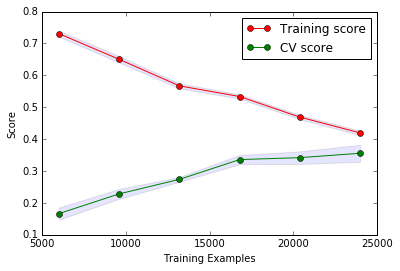

In [140]:
plotLearningCurve(logReg, X, Y)
print "Logistic Regression Learning Curve"

The training score and cross validation score look like they are converging as the number of elements in our training set increases. This means that adding more data won't fix the problem, and the root of the problem lies with the algorithm having a high bias. We could try to fix this by extracting some more features from our dataset. Lets add some information about the rhythm:

In [54]:
import pywt

def discreteWaveletTransform(data):
    cA, cD = pywt.dwt(data, 'db4')
    return cA

def lowPassFilter(data):
    alpha = 0.99
    data[0] = (1-alpha)*(data[0])
    
    for x in range(1,len(data)):
        data[x] = (1-alpha)*(data[x]) + (alpha*data[x-1])
    return data

def downSample(data):
    downSampleBy = 16
    newData = np.empty([len(data)/16])
    lenData = len(newData)
    for x in range(0,lenData):
        newData[x] = data[x*downSampleBy]
    return newData

def meanRemoval(data):
    mean = np.mean(data)
    for x in range(0,len(data)):
        data[x] = data[x] - mean
    return data


def autocorrelation(data, numPeaks):
    newData = np.empty([len(data)])
    lenData = len(data)
    peaks = []
    lastIntercept = 0
    for k in range(0, lenData):
        corr = 0
        for n in range(k,lenData):
            corr += data[n]*data[n-k]
        
        newData[k] = corr/(lenData*1.0)
        #Reached a peak
        if (k > 0 and newData[k-1] * newData[k] < 0):
            peaks.append(max(newData[lastIntercept:k]))
            lastIntercept = k
        if len(peaks) >= numPeaks:
            break
    return peaks


In [137]:
def getBeatData(fileData):
    analysisWindowSize = 512
    analysisWindowsPerTextureWindow = 43
    textureWindowSize = analysisWindowsPerTextureWindow*analysisWindowSize
    fixedFrames = fileData.frames(textureWindowSize)
    numFrames = len(fixedFrames)-1
    audioData = np.zeros(shape = (numFrames ,19))

    print len(audioData)
    adIndexCount = 0
    #For Each Texture Window
    for x in range(0,numFrames-1):
        currCol = 0
        textureWindow = fileData[x*textureWindowSize:(x+1)*textureWindowSize]
        textureWindow = discreteWaveletTransform(textureWindow)
        
        #Full Wave Rectification
        textureWindow = np.absolute(textureWindow)
        
        audioData[x][currCol] = np.sum(textureWindow)
        currCol+=1
        
        #Low-Pass Filtering
        textureWindow = lowPassFilter(textureWindow)
        audioData[x][currCol] = np.sum(textureWindow)
        currCol+=1
        #DownSampling
        textureWindow = downSample(textureWindow)
        audioData[x][currCol] = np.sum(textureWindow)
        currCol+=1
        #Mean Removal
        textureWindow = meanRemoval(textureWindow)
        audioData[x][currCol] = np.sum(textureWindow)
        currCol+=1
        
    
        
    return audioData



In [ ]:
#plotLearningCurve(rfc, X, Y)
#train_sizes, train_scores, cv_scores = learning_curve(rfc, X, Y, train_sizes=np.linspace(0.25, 1.0, 6), cv=5)